In [1]:
import numpy as np
from scipy.ndimage import median_filter
from scipy.stats import rankdata
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from scipy.ndimage import median_filter

In [2]:
def adapmedfilt(noisy, Smax):
    """Apply adaptive median filter."""
    denoised = noisy.copy()
    already_processed = np.zeros(noisy.shape, dtype=bool)

    for k in range(3, Smax+1, 2):
        zmin = median_filter(noisy, size=k, mode='reflect', footprint=np.ones((k, k)))
        zmax = median_filter(noisy, size=k, mode='reflect', footprint=np.ones((k, k)))
        zmed = median_filter(noisy, size=k, mode='reflect')

        process_using_level_b = (zmed > zmin) & (zmax > zmed) & ~already_processed
        zB = (noisy > zmin) & (zmax > noisy)

        output_zxy = process_using_level_b & zB
        output_zmed = process_using_level_b & ~zB

        denoised[output_zxy] = noisy[output_zxy]
        denoised[output_zmed] = zmed[output_zmed]

        already_processed |= process_using_level_b
        if already_processed.all():
            break

    denoised[~already_processed] = zmed[~already_processed]
    return denoised

In [3]:
import numpy as np

def patchmatcher(patchArr, refj, refk, frameno):
    """
    Find 5 closest matches for the reference patch from each frame.
    
    Parameters:
        patchArr : numpy array, shape [64, dim1, dim2, nframes] (uint8)
            Vectorized patches of the video.
        refj     : int
            j index of the reference patch.
        refk     : int
            k index of the reference patch.
        frameno  : int
            Frame number of the reference patch.
    
    Returns:
        indices : numpy array, shape [3, nframes*5] (uint8)
            Indices of matching patches, [j, k, frame] for each match.
    """
    _, dim1, dim2, nframes = patchArr.shape

    # Cast patchArr to double for computation
    patch = patchArr.astype(np.float64)
    
    # Compute the L1 norm distance matrix
    M_ = np.sum(np.abs(patch - patch[:, refj, refk, frameno].reshape(64, 1, 1, 1)), axis=0)
    M = M_.reshape(dim1 * dim2, nframes)
    
    # Find indices of the 5 smallest distances in each frame
    I_ = np.argsort(M, axis=0)[:5].flatten()

    # Convert flattened indices to j, k coordinates
    row, col = np.unravel_index(I_, (dim1, dim2))

    # Reshape to form indices [j, k, frame] for each match
    indices = np.vstack([row.reshape(1, -1), col.reshape(1, -1), np.repeat(np.arange(1, nframes + 1), 5)])

    # Convert indices to uint8 for consistency
    indices = indices.astype(np.uint8)
    
    return indices

In [4]:
def svti(p, omega, tau, kmax, tol, sec_missing):
    """Apply SVT to remove noise and fill in missing pixels."""
    n2 = p.shape[1]
    sigma_bar = np.array([np.std(p[i, omega[i, :]]) for i in range(64)])

    if sec_missing:
        for i in range(64):
            mu_bar = np.mean(p[i, omega[i, :]])
            omega[i, :] &= (p[i, :] <= mu_bar + 2 * sigma_bar[i]) & (p[i, :] >= mu_bar - 2 * sigma_bar[i])

    sigma_hat = np.mean(sigma_bar)
    p_val = omega.sum() / omega.size
    mu = (8 + np.sqrt(n2)) * np.sqrt(p_val) * sigma_hat
    lambda_ = tau * mu

    q = np.zeros_like(p)
    for k in range(kmax):
        p_ = q - p
        p_[~omega] = 0
        r = q - tau * p_
        u, s, vt = np.linalg.svd(r, full_matrices=False)
        q_new = u @ np.diag(np.maximum(s - lambda_, 0)) @ vt

        if np.linalg.norm(q_new - q, 'fro') <= tol:
            q = q_new
            break
        q = q_new
    return q, k

In [5]:
'''def lrmc(noisy, frameno, tau, kmax, tol, variant):
    """Using Low Rank Matrix Completion to denoise video."""
    dim1, dim2, nframes = noisy.shape
    sec_missing, replace = variant == '10', variant == '11'

    #filtered = np.array([adapmedfilt(noisy[:, :, i], 11) for i in range(nframes)], dtype=np.uint8)
    # use scipy median fitler instead
    print(noisy[:, :, 0].shape)
    filtered = np.array([median_filter(noisy[:, :, i], size=11) for i in range(nframes)], dtype=np.uint8)
    filtered = filtered.reshape(dim1, dim2, nframes)
    print('filtered', filtered.shape)
    print('noisy', noisy.shape)
    missing = filtered != noisy

    patch_arr = np.zeros((64, dim1 // 4 - 1, dim2 // 4 - 1, nframes), dtype=np.uint8)
    missing_arr = np.zeros_like(patch_arr, dtype=bool)

    for i in range(nframes):
        for j in range(dim1 // 4):
            for k in range(dim2 // 4):
                patch_arr[:, j, k, i] = filtered[4 * j:4 * (j + 1), 4 * k:4 * (k + 1), i].reshape(64)
                missing_arr[:, j, k, i] = missing[4 * j:4 * (j + 1), 4 * k:4 * (k + 1), i].reshape(64)
    
    denoised_patch_arr = np.zeros_like(patch_arr, dtype=float)
    for refj in tqdm(range(dim1 // 4 - 1)):
        for refk in range(dim2 // 4 - 1):
            indices = patchmatcher(patch_arr, refj, refk, frameno)
            patch_mat = np.array([patch_arr[:, idx[0], idx[1], idx[2]] for idx in indices.T])
            patch_omega = np.array([~missing_arr[:, idx[0], idx[1], idx[2]] for idx in indices.T])

            denoised_patch_mat, _ = svti(patch_mat.T.astype(float), patch_omega.T, tau, kmax, tol, sec_missing)
            if replace:
                patch_arr[:, refj, refk, frameno] = denoised_patch_mat[:, indices.shape[1] // 2]

            denoised_patch_arr[:, refj, refk, frameno] = denoised_patch_mat[:, indices.shape[1] // 2]

    recon = np.zeros(filtered.shape, dtype=float)
    weight = np.zeros_like(recon)

    for i in tqdm(range(nframes)):
        for j in range(dim1 // 4 - 1):
            for k in range(dim2 // 4 - 1):
                recon[4 * j:4 * (j + 2), 4 * k:4 * (k + 2), i] += denoised_patch_arr[:, j, k, i].reshape(8, 8)
                weight[4 * j:4 * (j + 2), 4 * k:4 * (k + 2), i] += 1

    recon /= weight
    return recon.astype(np.uint8), filtered'''

'def lrmc(noisy, frameno, tau, kmax, tol, variant):\n    """Using Low Rank Matrix Completion to denoise video."""\n    dim1, dim2, nframes = noisy.shape\n    sec_missing, replace = variant == \'10\', variant == \'11\'\n\n    #filtered = np.array([adapmedfilt(noisy[:, :, i], 11) for i in range(nframes)], dtype=np.uint8)\n    # use scipy median fitler instead\n    print(noisy[:, :, 0].shape)\n    filtered = np.array([median_filter(noisy[:, :, i], size=11) for i in range(nframes)], dtype=np.uint8)\n    filtered = filtered.reshape(dim1, dim2, nframes)\n    print(\'filtered\', filtered.shape)\n    print(\'noisy\', noisy.shape)\n    missing = filtered != noisy\n\n    patch_arr = np.zeros((64, dim1 // 4 - 1, dim2 // 4 - 1, nframes), dtype=np.uint8)\n    missing_arr = np.zeros_like(patch_arr, dtype=bool)\n\n    for i in range(nframes):\n        for j in range(dim1 // 4):\n            for k in range(dim2 // 4):\n                patch_arr[:, j, k, i] = filtered[4 * j:4 * (j + 1), 4 * k:4 * (k + 

In [6]:
def lrmc(noisy, frameno, tau, kmax, tol, variant):
    # Set default options based on variant
    if variant == '00':
        sec_missing = False
        replace = False
    elif variant == '01':
        sec_missing = False
        replace = True
    elif variant == '10':
        sec_missing = True
        replace = False
    elif variant == '11':
        sec_missing = True
        replace = True
    else:
        print("Warning: incorrect variant - setting to default variant: 01")
        sec_missing = False
        replace = True

    dim1, dim2, nframes = noisy.shape

    # Applying adaptive median filter
    filtered = np.zeros((dim1, dim2, nframes), dtype=np.uint8)
    for i in tqdm(range(nframes)):
        filtered[:, :, i] = median_filter(noisy[:, :, i], size=11)

    # First subset of missing pixels
    missing = (filtered != noisy)

    # Generating patch array and missing array
    patchArr = np.zeros((64, dim1 // 4 - 1, dim2 // 4 - 1, nframes), dtype=np.uint8)
    missingArr = np.zeros_like(patchArr, dtype=bool)

    for i in tqdm(range(nframes)):
        for j in range(dim1 // 4 - 1):
            for k in range(dim2 // 4 - 1):
                patchArr[:, j, k, i] = filtered[4*j:4*(j+2), 4*k:4*(k+2), i].reshape(64)
                missingArr[:, j, k, i] = missing[4*j:4*(j+2), 4*k:4*(k+2), i].reshape(64)

    # Iteratively denoising each patch
    denoisedpatchArr = np.zeros_like(patchArr, dtype=np.float64)
    for refj in tqdm(range(dim1 // 4 - 1)):
        for refk in range(dim2 // 4 - 1):
            indices = patchmatcher(patchArr, refj, refk, frameno)
            patchMat = np.zeros((64, indices.shape[1]), dtype=np.uint8)
            patchOmega = np.zeros((64, indices.shape[1]), dtype=bool)

            for i in range(indices.shape[1]):
                patchMat[:, i] = patchArr[:, indices[0, i], indices[1, i], indices[2, i]]
                patchOmega[:, i] = ~missingArr[:, indices[0, i], indices[1, i], indices[2, i]]

            denoisedpatchMat, _ = svti(patchMat.astype(np.float64), patchOmega, tau, kmax, tol, sec_missing)

            for selfind in range(5 * (frameno - 1), 5 * frameno):
                if np.array_equal(indices[:, selfind], [refj, refk, frameno]):
                    break

            if replace:
                patchArr[:, refj, refk, frameno] = denoisedpatchMat[:, selfind]
            denoisedpatchArr[:, refj, refk, frameno] = denoisedpatchMat[:, selfind]

    # Averaged reconstruction from denoised patch array
    recon = np.zeros_like(filtered, dtype=np.float64)
    weight = np.zeros_like(recon)
    for i in tqdm(range(nframes)):
        for j in range(dim1 // 4 - 1):
            for k in range(dim2 // 4 - 1):
                recon[4*j:4*(j+2), 4*k:4*(k+2), i] += denoisedpatchArr[:, j, k, i].reshape(8, 8)
                weight[4*j:4*(j+2), 4*k:4*(k+2), i] += 1

    recon = (recon / weight).astype(np.uint8)
    return recon, filtered


In [7]:
def noisemodel(frames, sigma, k, s):
    """
    Add Gaussian, Poisson, and Impulsive noise to the video.

    Parameters:
    frames (np.ndarray): Original video of shape (dim1, dim2, nframes) (uint8).
    sigma (float): Standard deviation of Gaussian noise.
    k (float): Variance factor of Poisson noise.
    s (float): Percentage of impulsive noise.

    Returns:
    np.ndarray: Noisy video of shape (dim1, dim2, nframes) (uint8).
    """
    dim1, dim2, nframes = frames.shape

    # Convert frames to float for noise addition
    noisy = frames.astype(np.float64)

    # Poisson Noise
    np_noise = np.random.poisson(k * noisy) - k * noisy

    # Gaussian Noise
    ng = sigma * np.random.randn(dim1, dim2, nframes)

    # Combine noises
    noisy += np_noise + ng

    # Impulsive noise
    X = np.random.rand(dim1, dim2, nframes)
    noisy[X < s / 200] = 0  # Set impulsive noise to 0
    noisy[X > 1 - s / 200] = 255  # Set impulsive noise to 255

    # Cast back to uint8
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

    return noisy

In [8]:
def read_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # List to store frames
    frames = []
    
    # Read frames from the video
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit if there are no more frames
        
        # Convert frame to grayscale (if needed)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Convert to uint8
        gray_frame = gray_frame.astype(np.uint8)
        
        # Append the frame to the list
        frames.append(gray_frame)

    # Release the video capture object
    cap.release()
    
    # Convert list of frames to a numpy array
    video_data = np.array(frames)
    return video_data

In [9]:
data = read_video('../data/carphone_qcif.y4m')
data.shape

(382, 144, 176)

In [10]:
data[0].shape

(144, 176)

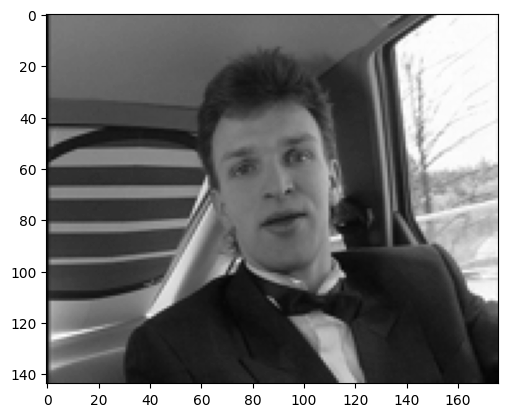

In [11]:
plt.imshow(data[0], cmap='gray')

382 quadros de dimensão 176x144.

In [12]:
nnn = noisemodel(data, 10, 0.01, 5)

In [13]:
# play the video
'''fig, ax = plt.subplots()
img_display = ax.imshow(noisy[0], cmap='gray')
ax.axis('off')  # Hide the axes

def update(frame):
    img_display.set_array(noisy[frame])
    return img_display,

ani = animation.FuncAnimation(fig, update, frames=range(noisy.shape[0]), interval=100)

# save to compressed format
ani.save('../noisy.mp4', writer='ffmpeg', fps=30)'''

"fig, ax = plt.subplots()\nimg_display = ax.imshow(noisy[0], cmap='gray')\nax.axis('off')  # Hide the axes\n\ndef update(frame):\n    img_display.set_array(noisy[frame])\n    return img_display,\n\nani = animation.FuncAnimation(fig, update, frames=range(noisy.shape[0]), interval=100)\n\n# save to compressed format\nani.save('../noisy.mp4', writer='ffmpeg', fps=30)"

In [14]:
nnn.shape

(382, 144, 176)

In [15]:
noisy_cast = nnn.reshape((144, 176, 382))

In [16]:
frameno = 10
tau = 1.5
kmax = 30
tol = 1e-5
variant = '01'

recon, filtered = lrmc(noisy_cast, frameno, tau, kmax, tol, variant)

100%|██████████| 382/382 [00:07<00:00, 50.58it/s]


In [19]:
# save filtered
#np.save('filtered.npy', filtered)

In [20]:
fil_res = filtered.reshape((382, 144, 176))
fil_res

array([[[ 80,  75,  81, ...,  95,  90,  91],
        [ 68,  79,  94, ..., 104, 103, 104],
        [ 66, 100,  96, ...,  87,  88,  90],
        ...,
        [ 51,  65,  71, ...,  82,  90,  79],
        [ 68,  84,  76, ...,  79,  85,  86],
        [ 79,  76,  77, ...,  97,  87,  94]],

       [[ 56,  86,  84, ...,  98,  88,  85],
        [ 67,  83,  79, ...,  88,  86,  82],
        [ 77,  68,  79, ..., 102, 100,  91],
        ...,
        [ 53,  73,  66, ...,  91,  90,  74],
        [ 60,  74,  82, ...,  81,  86,  89],
        [ 72,  76,  86, ...,  82,  89,  87]],

       [[ 72,  87,  92, ...,  95,  85,  85],
        [ 82,  76,  77, ..., 103,  97,  97],
        [ 77,  83,  88, ...,  89,  91,  79],
        ...,
        [ 64,  78,  75, ...,  92,  82,  73],
        [ 74,  81,  83, ...,  86,  91,  91],
        [ 76,  86,  75, ...,  89, 101,  94]],

       ...,

       [[ 78,  85,  77, ...,  94,  99,  96],
        [ 80,  85,  81, ...,  94,  93,  87],
        [ 81,  79,  83, ...,  91,  95,  86